In [1]:
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
import joblib
import numpy as np
from statannotations.Annotator import Annotator

from helper.evaluation_helper import hyperparameter_search, cv_evaluate

network_type = "large"
target_db = "DC"

In [2]:
scoring = "balanced_accuracy"
n_estimators = 10
random_state = 61022
n_iter = 3

original = pd.read_csv(f'../../../2_feature_extraction/{network_type}/features_{target_db} Target.csv', index_col=0)
original = original.drop(['Target', 'Neighbor'], axis=1)
original = original[original['Outcome'] != 'Very Weak']
original = original[original['Outcome'] != 'Low']
original['Outcome'] = original['Outcome'].replace({'Weak': 'Effect'})
original['Outcome'] = original['Outcome'].replace({'Strong': 'Effect'})
display(original.groupby('Outcome').count()['MolecularWeight'])
original['Outcome'] = original['Outcome'].replace({'No-Effect': 0, 'Cyto': -1, 'Effect': 1})
outcomes = ['No-Effect vs. Effect', 'No-Effect vs. Cyto', 'Cyto vs. Effect']
results = {}
results_random = {}
for outcome in outcomes:
    print(" "  + outcome)
    data = original.copy()
    os = outcome.split(' vs. ')
    drop_outcome = None
    if 'Effect' not in os:
        drop_outcome = 1
        data = data[data['Outcome'] != drop_outcome]
        data['Outcome'] = data['Outcome'].replace({-1: 1})
    elif 'Cyto' not in os:
        drop_outcome = -1
        data = data[data['Outcome'] != drop_outcome]
    elif 'No-Effect' not in os:
        drop_outcome = 0
        data = data[data['Outcome'] != drop_outcome]
        data['Outcome'] = data['Outcome'].replace({-1: 0})
    else:
        raise Exception()

    data = data.dropna()
    labels = data.copy().loc[:, 'Outcome']
    features = data.copy().drop('Outcome', axis=1)

    rs_results, cv_result, model, X_train, y_train, X_test, y_test = hyperparameter_search(features, labels, scoring=scoring, random_state=random_state, n_estimators=n_estimators, n_iter=n_iter)
    results[outcome] = {'hyperparameter_search': rs_results, 'cv_evaluation': cv_result, 'model': model, 'X_train': X_train, 'y_train': y_train, 'X_test': X_test, 'y_test': y_test}
    rs_results_random, cv_result, model, _, _, _, _ = hyperparameter_search(features, labels.sample(frac=1.0), scoring=scoring, random_state=random_state, n_estimators=n_estimators, n_iter=n_iter)
    results_random[outcome] = {'hyperparameter_search': rs_results_random, 'cv_evaluation': cv_result, 'model': model}

target_results = {'real': results, 'random': results_random}

joblib.dump(target_results, 'results.sav')

Outcome
Cyto           16
Effect         88
No-Effect    1019
Name: MolecularWeight, dtype: int64

 No-Effect vs. Effect
 No-Effect vs. Cyto
 Cyto vs. Effect


['results.sav']

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


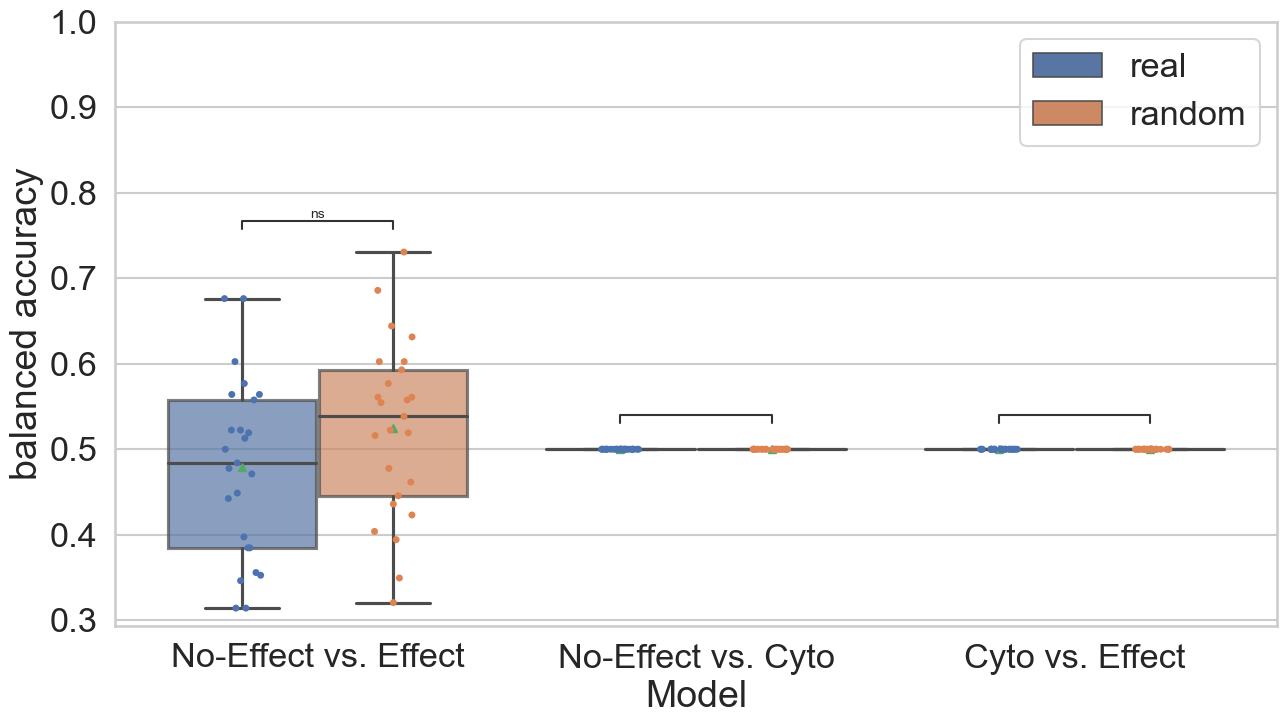

In [3]:
target_result = joblib.load('results.sav')

model_evaluations = []


results = target_results['real']
for key in results.keys():
    result = results[key]['cv_evaluation'].loc[:, 'test_score'].to_frame()
    result['model'] = key
    result['labels'] = 'real'
    model_evaluations.append(result)

results_random = target_results['random']
for key in results.keys():
    result_random = results_random[key]['cv_evaluation'].loc[:, 'test_score'].to_frame()
    result_random['model'] = key
    result_random['labels'] = 'random'
    model_evaluations.append(result_random)

scores = pd.concat(model_evaluations)

sns.set("talk", font_scale=1.5)
sns.set_style("whitegrid")
fig, ax = plt.subplots(1, 1, figsize=(15, 8), dpi=100)
sns.boxplot(data=scores, x='model', y='test_score', hue='labels', showmeans=True, ax=ax, boxprops=dict(alpha=.7))
sns.stripplot(data=scores, x='model', y='test_score', hue='labels', ax=ax, dodge=True, jitter=True, alpha=1.0)
pairs = [(('No-Effect vs. Cyto', 'real'), ('No-Effect vs. Cyto', 'random')),
         (('No-Effect vs. Effect', 'real'), ('No-Effect vs. Effect', 'random')),
         (('Cyto vs. Effect', 'real'), ('Cyto vs. Effect', 'random'))]
annotator = Annotator(ax, pairs, data=scores, x="model", y="test_score", hue="labels")
annotator.configure(test='t-test_welch', text_format='star', loc='inside', verbose=0, text_offset=0, line_offset=0.0)
annotator.apply_and_annotate()
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles[:2], labels[:2])
ax.set(ylabel='balanced accuracy')
ax.set(xlabel='Model')
ax.set(yticks=np.arange(0.3, 1.1, step=0.1))
fig.savefig('cv_evaluation.png', format="png", dpi=300)
fig.savefig('cv_evaluation.eps', format="eps", dpi=300)
fig.savefig('cv_evaluation.pdf', format="pdf", dpi=300)
fig.savefig('cv_evaluation.svg', format="svg", dpi=300)